<table>
<td height="150px">
<img src='https://stergioc.github.io/assets/img/logos.png' />
</td>
</table>

# Purpose of the project

## Explanation

This notebook is aimed to recognize, thanks to Convolutional Neural Networks (CNN), tumors in [histopathology patches](https://en.wikipedia.org/wiki/Histopathology). This data corresponds to digitized microscopic analysis of tumor tissue, which has been divided into patches. The objective is to classify the patches into the ones containing tumor tissue, and ones not containing any tumor tissue. We will use the [PCAM dataset](https://github.com/basveeling/pcam) which consists of 96x96 pixel patches. We will only use the validation set (which contains 32768 patches and which should take about 0.8 GB of storage) in order to make the training faste

## Metrics and Loss

As we are dealing with tumor, we don't want to miss any false negative, that is telling the patient that everything is ok while it isn't.
Recall could be a good metric, but it happens that if the model predicts every sample as 1s, the recall is 100% but the model predicts poorly.
**We will thus focus on recall and precision, thanks to the F1 score. **

The loss is simply the **Binary Cross Entropy Loss**, that is used thanks to BCEwithLogitsLoss() function of Pytorch.

## Outline of the project

1. Data Import
2. Data Inspection
3. Creation of the dataset (normalize, reshape etc...)
4. Definition of 3 types of CNN models (ConvReluPool, ConvConvPool, Resnet)
5. Training each model
6. Evaluation of them
7. Hyperparameter tuning on the most promising (thanks to `gp_minimize`)
8. Trying a Vision Transformer (ViT)
9. Give some explanability of the model thanks to LIME and Saliency Maps

Let's go !

# I. Data Import

In [ ]:
import h5py
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_file_from_google_drive, _decompress
import matplotlib.pyplot as plt
from tqdm import tqdm

### I.1. Download the dataset which is stored in a `.h5` file.
The images can be download from [here](https://drive.google.com/uc?export=download&id=1hgshYGWK8V-eGRy8LToWJJgDU_rXWVJ3), and the labels from [here](https://drive.google.com/uc?export=download&id=1bH8ZRbhSVAhScTS0p9-ZzGnX91cHT3uO)

In [ ]:
from torchvision.datasets.utils import download_file_from_google_drive, _decompress

# You can run the following cell to download the files on colab
base_folder = "./"
archive_name = "camelyonpatch_level_2_split_valid_x.h5.gz"
download_file_from_google_drive("1hgshYGWK8V-eGRy8LToWJJgDU_rXWVJ3", base_folder, filename=archive_name, md5="d5b63470df7cfa627aeec8b9dc0c066e")
_decompress(base_folder + archive_name)

archive_name = "camelyonpatch_level_2_split_valid_y.h5.gz"
download_file_from_google_drive("1bH8ZRbhSVAhScTS0p9-ZzGnX91cHT3uO", base_folder, filename=archive_name, md5="2b85f58b927af9964a4c15b8f7e8f179")
_decompress(base_folder + archive_name)

In [ ]:
#We copy the path given in Google Colab
IMAGES_PATH ="content/camelyonpatch_level_2_split_valid_x.h5"
LABELS_PATH ="content/camelyonpatch_level_2_split_valid_y.h5"

In [ ]:
IMAGES_PATH = os.path.join(data_dir, IMAGES_PATH)
LABELS_PATH = os.path.join(data_dir, LABELS_PATH)

In [ ]:
images = np.array(h5py.File(IMAGES_PATH)['x'])
labels = np.array([y.item() for y in h5py.File(LABELS_PATH)['y']])

# II. Data Inspection

Let's see the shape of the images :

In [ ]:
images.shape

(32768, 96, 96, 3)

We thus have 32k images, each RGB with 96x96 pixels.

Let's understand the structure of each image :

In [ ]:
images[0]

array([[[224, 111, 191],
        [239, 130, 209],
        [230, 127, 206],
        ...,
        [152,  82, 170],
        [224, 147, 225],
        [212, 131, 200]],

       [[177,  63, 150],
        [188,  78, 164],
        [177,  73, 158],
        ...,
        [215, 145, 234],
        [224, 147, 227],
        [215, 135, 208]],

       [[208,  99, 192],
        [194,  87, 181],
        [173,  70, 162],
        ...,
        [176, 105, 197],
        [203, 128, 210],
        [211, 133, 208]],

       ...,

       [[ 88,  31, 134],
        [ 94,  38, 137],
        [137,  82, 176],
        ...,
        [158,  99, 189],
        [110,  50, 140],
        [119,  58, 151]],

       [[155,  95, 193],
        [132,  75, 170],
        [ 85,  29, 118],
        ...,
        [121,  63, 148],
        [ 97,  38, 128],
        [127,  68, 160]],

       [[151,  90, 185],
        [131,  72, 164],
        [115,  57, 142],
        ...,
        [166, 108, 192],
        [122,  64, 151],
        [ 81,  25, 114]]

An image has thus 3 channels (RGB) with value in range 0 to 255.
We will need
- 1) to normalize each image (by dividing by 255 and taking the mean/std of ImageNet)
- 2) Resize in a power of 2 to increase the speed of computation (128x128 as 64x64 would crop too much data : the tumor is not expected to always be centered).

### II.2. Split it into a training and a validation set
Now that we have the data, we will want to split it into a training and a validation set. For this, we will write a function which takes in as input the size of the dataset, and which will return the indices of the training set and the indices of the validation set.

In [ ]:
random.seed(0)

In [ ]:
def get_split_indices(dataset_length, train_ratio=0.7):
    """
    Function which splits the data into training and validation sets.
    arguments:
        dataset_length [int]: number of elements in the dataset
        train_ratio [float]: ratio of the dataset in the training set
    returns:
        train_indices [list]: list of indices in the training set (of size dataset_length*train_ratio)
        val_indices [list]: list of indices in the validation set (of size dataset_length*(1-train_ratio))
    """
    #First, we do a random permutation of all the indexes
    indexes = [i for i in range(dataset_length)]
    random.shuffle(indexes) #method without output

    #Then, we round up to the next integer
    train_indices = indexes[:int(np.floor(train_ratio*dataset_length))]
    val_indices = indexes[int(np.floor(train_ratio*dataset_length)):]

    return train_indices, val_indices

In [ ]:
train_indices, val_indices = get_split_indices(len(labels))

Let's check if we have any common indices :

In [ ]:
set(train_indices).intersection(val_indices)

set()

No ! great !

# III. Creation of the Dataset
Pytorch has an implemented PCAM dataset class, but we will code these from scratch.

The dataset is pretty simple :

- 1) We normalize each picture thanks to the mean and std of ImageNet
- 2) We use use various transformations as data augmentation on the training set (not necessary to compute them on the validation set).

In [ ]:
class PCAMDataset(Dataset):
    def __init__(self, data, labels, train):
        """
        Dataset class for the PCAM dataset.
        arguments:
            data [numpy.array]: all RGB 96-96 images
            labels [numpy.array]: corresponding labels
            train [bool]: whether the dataset is training or validation for transformation
            means [tensor] : mean values RGB of ImageNet
            stds [tensor] : std values RGB of ImageNet
        """
        super(PCAMDataset, self).__init__()
        self.data = data
        self.labels = labels


        #In any case (train or validation), we normalize the data
        self.data = data/255

        if train : # we use certain transformations to augment the dataset

          self.transform = transforms.Compose([transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]),
                                              transforms.RandomHorizontalFlip(p=0.5),
                                              transforms.RandomVerticalFlip(p=0.5),
                                              transforms.RandomRotation(30),
                                              transforms.Resize((128,128), antialias=True)])

        else : #we don't use certain transformations in test mode
          self.transform = transforms.Compose([transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]),
                                              transforms.Resize((128,128), antialias=True)])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]

        # Apply transformations
        img = self.transform(img)
        img = img.float() #conversion to match the type of the bias in the CNN layers
        return img, label

And we can instanciate our datasets and dataloaders :

In [ ]:
BATCH_SIZE =64

train_dataset = PCAMDataset(images[train_indices], labels[train_indices], train=True)
val_dataset = PCAMDataset(images[val_indices], labels[val_indices], train=False)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Let's check if our DataLoaders are working :

In [ ]:
for img, label in train_dataloader :
  print(img.shape)
  break

torch.Size([64, 3, 128, 128])


## III.1 Display of a random sample of images
that have a label of 0 (not containing
any tumor tissue) and 1 (containing tumor tissue).

Here, we want to see how our image are, typically after some transformations. As they are normalized, we need to denormalize them to see the colors back.

In [ ]:
mean = torch.Tensor([0.485, 0.456, 0.406]) # Channel mean of ImageNet
std = torch.Tensor([0.229, 0.224, 0.225]) # Channel standard Deviation of ImageNet
DeNormalize = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ], std = 1/std), transforms.Normalize(mean = -mean, std = [ 1., 1., 1. ]),])
tensor_images, labels = next(iter(train_dataloader))
tensor_images = DeNormalize(tensor_images)

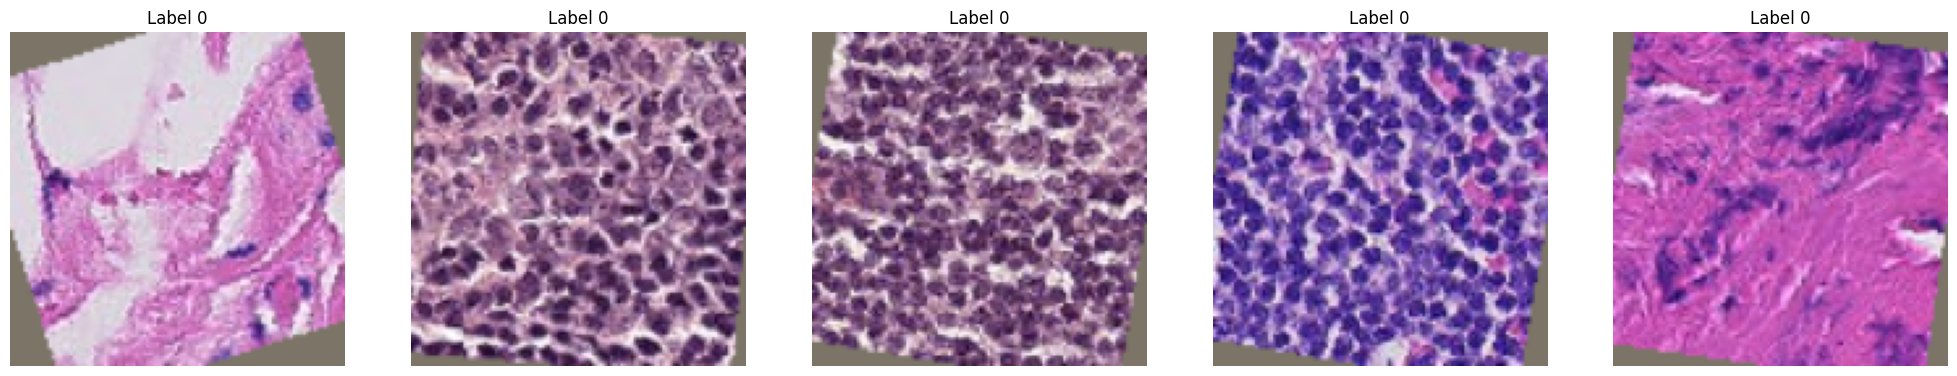

In [ ]:
fig, axes = plt.subplots(figsize=(25, 50) ,ncols=5)

# Plot images with label 0
label_0_indices = (labels == 0).nonzero().squeeze(1)[:5]  # Choose the first 5 indices with label 0
for ii, index in enumerate(label_0_indices):
    ax = axes[ii]
    ax.imshow((tensor_images[index]).permute(1, 2, 0))
    ax.set_title(f"Label 0")
    ax.axis('off')

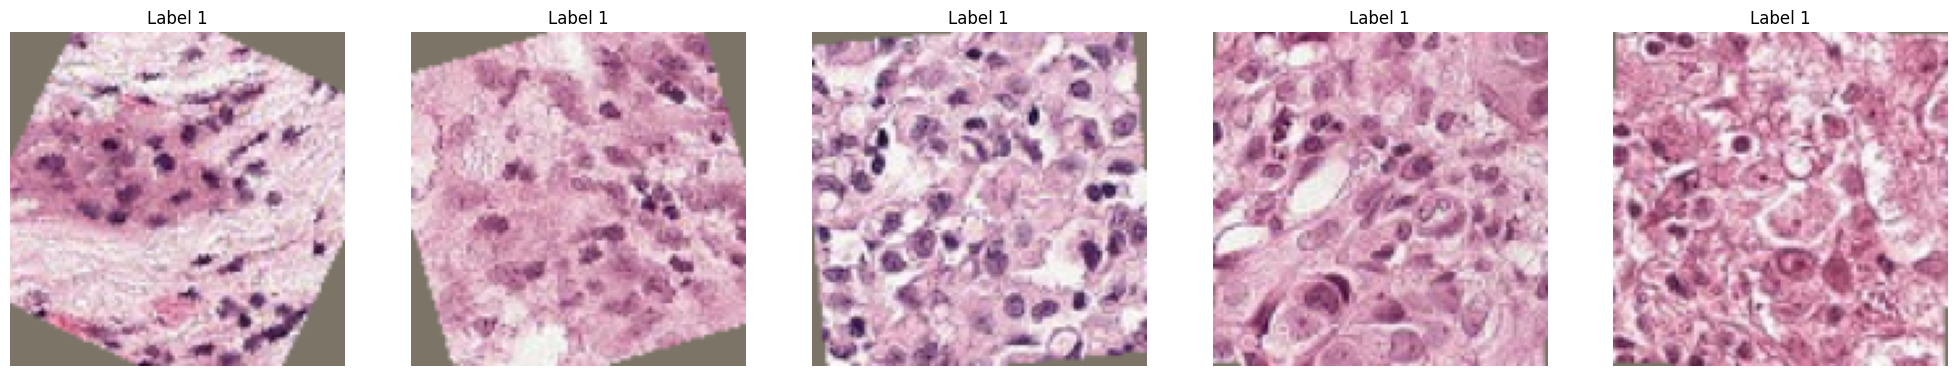

In [ ]:
# Plot images with label 1
fig, axes = plt.subplots(figsize=(25, 50) ,ncols=5)

label_1_indices = (labels == 1).nonzero().squeeze(1)[:5]  # Choose the first 5 indices with label 1
for ii, index in enumerate(label_1_indices):
    ax = axes[ii]
    ax.imshow((tensor_images[index]).permute(1, 2, 0))
    ax.set_title(f"Label 1")
    ax.axis('off')

plt.show()

It's pretty hard to see where a tumor is ! We can guess that any big spot can be considered as it, or that the skin is kind of skewed.

## III.2. Plot of the distribution
We want to see how well the classes are balanced.

In [ ]:
train_class_counts=[sum(train_dataset.labels == i) for i in range(2)]
val_class_counts = [sum(val_dataset.labels == i) for i in range(2)]

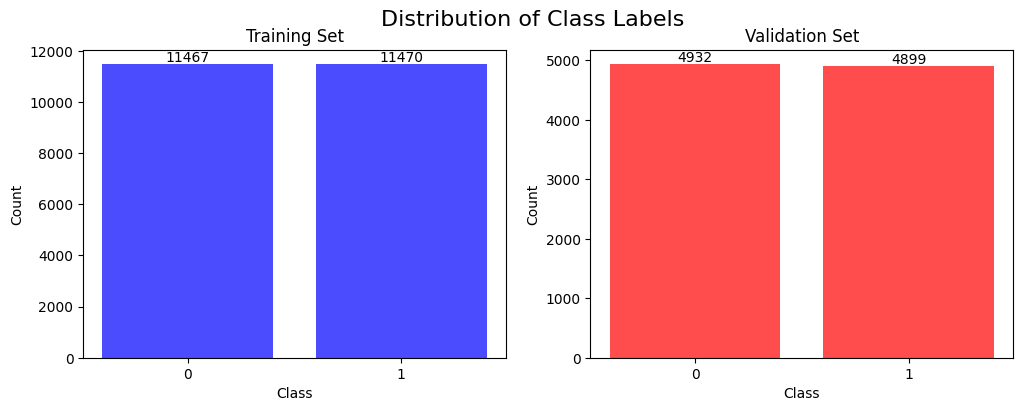

In [ ]:
# Plotting the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Distribution of Class Labels', fontsize=16)

# Training set distribution
ax1.bar(range(2), train_class_counts, color='blue', alpha=0.7)
ax1.set_title('Training Set')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticks(range(2))
ax1.set_xticklabels(range(2))

for i, count in enumerate(train_class_counts):
    ax1.text(i, count + 0.1, str(count), ha='center', va='bottom')

# Validation set distribution
ax2.bar(range(2), val_class_counts, color='r', alpha=0.7)
ax2.set_title('Validation Set')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_xticks(range(2))
ax2.set_xticklabels(range(2))

for i, count in enumerate(val_class_counts):
    ax2.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()


We have a balanced dataset in each training and validation sets, so there is no need for data balancement.

# IV. Models architecture

As deep learning is a lot of try-and-see, I want to compare 3 types of architectures.

1. ConvReluPool Models : adding blocks of ConvReluMaxPooling before 2 fully connected layers
2. ConvConvPool Models : adding blocks of [Conv-Relu-Conv)Relu-MaxPooling] before 2 fully connected layers
2. Resnets : using ResNet18 and ResNet34 models.

We define all classes in this sections, then train all instanciated models, and finally evaluate them.
- *NB : As we are doing a binary classification, we can choose to have 1 or 2 neurons for the final layer. I chose to have 1 neuron without sigmoid, and compute it with BCEwithLogitsLoss that is said to be more stable.*

## IV.1 ConvReluPool Type Model

In [ ]:
class ConvReluPool(nn.Module):
    '''Class that builds a CNN for a certain number of input layers.
    We stack num_CNN_layers times (CONV2D, Relu, MaxPool).
    Each time this layer is built, we divide by 2 the input dimensions, and multiply by 2 the channel dimension.
    Eg : if we begin with 96x96x3,
    (first_layer): 48x48x32
    (second_layer): 24x24x64.

    At the end, we put 2 Fully Connected layers (128 -> 64-> num_classes) with dropout.'''
    def __init__(self,params):

        super(ConvReluPool, self).__init__()

        #We extract values that are given as input in a dictionary
        in_channels,input_dimension= params["shape_in"]
        num_CNN_blocks = params["num_CNN_blocks"]
        filter_dim = params["filter_dim"]
        fc_size = params["fc_size"]
        self.dropout_rate = params["dropout_rate"]

        layers = [] #we will stack layers according to the number of blocks

        for i in range(1,num_CNN_blocks+1):
            layers.append(nn.Conv2d(in_channels, i*filter_dim, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = i*filter_dim  # Update the number of input channels for the next layer

        # Flatten layer
        layers.append(nn.Flatten())

        # Fully connected layers

        layers.append(nn.Linear(input_dimension//(2**num_CNN_blocks) * input_dimension//(2**num_CNN_blocks)*in_channels, fc_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(self.dropout_rate))
        layers.append(nn.Linear(fc_size, 1))

        self.cnn_layers = nn.Sequential(*layers)

    def forward(self, x):

      return self.cnn_layers(x)

## IV.2 ConvConvPool Type

In [ ]:
class ConvConvPool(nn.Module):
    '''Class that builds a CNN for a certain number of input layers.
    We stack num_CNN_layers times (CONV2D, Relu, CONV2D,Relu, MaxPooling).

    At the end, we put 2 Fully Connected layers with dropout.'''
    def __init__(self,params):

        super(ConvConvPool, self).__init__()

        in_channels,input_dimension= params["shape_in"]
        num_CNN_blocks = params["num_CNN_blocks"]
        filter_dim = params["filter_dim"]
        fc_size = params["fc_size"]
        self.dropout_rate = params["dropout_rate"]

        layers = []

        for i in range(1,num_CNN_blocks+1):
            layers.append(nn.Conv2d(in_channels, (2**i)*filter_dim, kernel_size=3, stride=1, padding=1))
            layers.append(nn.Conv2d((2**i)*filter_dim, (2**i)*filter_dim, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = (2**i)*filter_dim  # Update the number of input channels for the next layer

        # Flatten layer
        layers.append(nn.Flatten())

        # Fully connected layers

        layers.append(nn.Linear(input_dimension//(2**num_CNN_blocks) * input_dimension//(2**num_CNN_blocks)*in_channels, fc_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(self.dropout_rate))
        layers.append(nn.Linear(fc_size, 1))

        self.cnn_layers = nn.Sequential(*layers)
    def forward(self, x):

      return self.cnn_layers(x)

## IV.3 ResNet

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")


        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion: int = 4

    def __init__(self, inplanes: int, planes: int, stride = 1, downsample = None,
                 groups = 1, base_width = 64, dilation = 1, norm_layer = None,):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:

            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 34, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    forward = _forward

def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

def resnet34(**kwargs):
    return ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)

## IV.4 Models Instanciations

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

Device used: cuda


We will instanciate 6 models :    
1. ConvReluPool with 2 CNN layers
2. ConvReluPool with 3 CNN layers
3. ConvConvPool with 2 CNN layers
4. ConvConvPool with 3 CNN layers
5. Resnet 18
6. Resnet 34

In [ ]:
params_model_2_blocks={
        "shape_in": (3,128),
        "num_CNN_blocks" : 2,
        "filter_dim": 8,
        "fc_size": 100,
        "dropout_rate": 0.25}

params_model_3_blocks={
        "shape_in": (3,128),
        "num_CNN_blocks" : 3,
        "filter_dim": 8,
        "fc_size": 100,
        "dropout_rate": 0.25}

# Create instantiation of Network class
CRP2 = ConvReluPool(params_model_2_blocks).to(device)
CRP3 = ConvReluPool(params_model_3_blocks).to(device)

# Create instantiation of Network class
CCP2 = ConvConvPool(params_model_2_blocks).to(device)
CCP3 = ConvConvPool(params_model_3_blocks).to(device)

resnet_18 = resnet18(num_classes=1).to(device)
resnet_34 = resnet34(num_classes=1).to(device)

## IV.5 Initialization of the training hyperparameters

NB : a greater learning rate doesn't make a good optimizer !

In [ ]:
lr = 3e-4

optimizer_CRP2 = torch.optim.Adam(CRP2.parameters(), lr = lr)
optimizer_CRP3 = torch.optim.Adam(CRP3.parameters(), lr = lr)

optimizer_CCP2 = torch.optim.Adam(CCP2.parameters(), lr = lr)
optimizer_CCP3 = torch.optim.Adam(CCP3.parameters(), lr = lr)

optimizer_resnet18 = torch.optim.Adam(resnet_18.parameters(), lr=lr)
optimizer_resnet34 = torch.optim.Adam(resnet_34.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss()

# V. Training

**During the training, we keep track of the loss (training and validation) and also the accuracy.
For the evaluation part, we will see if the model is overfitting or not, but most importantly see the recall score : in this medical case, we don't want to miss any tumor.**

## V.I. Training loop function

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def training_loop(model, epochs, train_dataloader, val_dataloader, optimizer, criterion, device):
    '''Function that trains a model, compute for each epoch predictions, and returns some metrics'''

    total_train_losses = [] #storing scores of all epochs
    total_val_losses = [] #storing scores of all epochs

    for epoch in range(1,epochs+1):
        print(f'epoch: {epoch}')
        ##TRAINING##
        model.train()

        train_losses = []
        train_labels = torch.Tensor([]) #We need to store all labels, batch by batch, to compute the accuracy score
        train_preds = torch.Tensor([]) #We need to store all predictions, batch by batch, to compute the accuracy score

        for img_batch, lbl_batch in tqdm(train_dataloader): #loop through all train dataloader

            train_labels=torch.cat((train_labels, lbl_batch)) #we append the labels of the batch
            img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)

            optimizer.zero_grad() #clear the gradient from the previous pass

            pred = model(img_batch) #result of the final neuron, without sigmoid
            preds = torch.sigmoid(pred) >= 0.5 #predicted labels

            train_preds=torch.cat((train_preds, preds.cpu())) #appeding predicted labels

            loss = criterion(pred.squeeze(), lbl_batch.squeeze().float()) #squeeze : [[0],[1]] to [0,1]
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        train_acc=accuracy_score(train_preds, train_labels)
        train_loss_mean = np.mean(train_losses) #mean of this batch
        total_train_losses.append(train_loss_mean)
        print(f"Train Loss :  {train_loss_mean:.4f} and Train Accuraccy :  {train_acc:.4f} ")

        ##VALIDATION##
        model.eval()
        val_losses = []
        val_labels = torch.Tensor([])
        val_preds = torch.Tensor([])
        with torch.no_grad():

            for img_batch, lbl_batch in tqdm(val_dataloader): #we compute the scores for the same epoch to compare scores

                val_labels=torch.cat((val_labels, lbl_batch)) # appending the label
                img_batch, lbl_batch = img_batch.to(device), lbl_batch.to(device)

                pred = model(img_batch)

                preds = torch.sigmoid(pred) >= 0.5

                val_preds=torch.cat((val_preds, preds.cpu()))

                loss = criterion(pred.squeeze(), lbl_batch.squeeze().float())
                val_losses.append(loss.item())


        val_acc=accuracy_score(val_preds, val_labels)
        val_loss_mean = np.mean(val_losses)
        total_val_losses.append(val_loss_mean)

        print(f"Val Loss :  {val_loss_mean:.4f} and Val Accuraccy :  {val_acc:.4f}")
        print('\n')

    return total_train_losses,total_val_losses, val_preds, val_labels

## V.2 Training models

We will train each of our 6 models, and store the results that we will display in the next section.

In [ ]:
num_epochs=15

In [ ]:
total_train_losses_CRP2,total_val_losses_CRP2, val_preds_CRP2, val_lbl_CRP2=training_loop(CRP2, num_epochs, train_dataloader, val_dataloader, optimizer_CRP2, criterion, device)

epoch: 1


100%|██████████| 359/359 [01:01<00:00,  5.87it/s]


Train Loss :  0.4572 and Train Accuraccy :  0.7800 


100%|██████████| 154/154 [00:08<00:00, 18.15it/s]


Val Loss :  0.4738 and Val Accuraccy :  0.7751


epoch: 2


100%|██████████| 359/359 [00:55<00:00,  6.44it/s]


Train Loss :  0.4204 and Train Accuraccy :  0.8055 


100%|██████████| 154/154 [00:07<00:00, 19.58it/s]


Val Loss :  0.4036 and Val Accuraccy :  0.8113


epoch: 3


100%|██████████| 359/359 [00:52<00:00,  6.83it/s]


Train Loss :  0.4058 and Train Accuraccy :  0.8112 


100%|██████████| 154/154 [00:07<00:00, 20.32it/s]


Val Loss :  0.3951 and Val Accuraccy :  0.8164


epoch: 4


100%|██████████| 359/359 [00:51<00:00,  6.91it/s]


Train Loss :  0.3971 and Train Accuraccy :  0.8185 


100%|██████████| 154/154 [00:07<00:00, 20.33it/s]


Val Loss :  0.3947 and Val Accuraccy :  0.8172


epoch: 5


100%|██████████| 359/359 [00:52<00:00,  6.88it/s]


Train Loss :  0.3809 and Train Accuraccy :  0.8279 


100%|██████████| 154/154 [00:07<00:00, 19.52it/s]


Val Loss :  0.3734 and Val Accuraccy :  0.8276


epoch: 6


100%|██████████| 359/359 [00:53<00:00,  6.70it/s]


Train Loss :  0.3736 and Train Accuraccy :  0.8289 


100%|██████████| 154/154 [00:07<00:00, 19.39it/s]


Val Loss :  0.3769 and Val Accuraccy :  0.8313


epoch: 7


100%|██████████| 359/359 [00:51<00:00,  6.91it/s]


Train Loss :  0.3658 and Train Accuraccy :  0.8352 


100%|██████████| 154/154 [00:08<00:00, 19.21it/s]


Val Loss :  0.3645 and Val Accuraccy :  0.8343


epoch: 8


100%|██████████| 359/359 [00:51<00:00,  6.91it/s]


Train Loss :  0.3620 and Train Accuraccy :  0.8401 


100%|██████████| 154/154 [00:08<00:00, 19.09it/s]


Val Loss :  0.3551 and Val Accuraccy :  0.8429


epoch: 9


100%|██████████| 359/359 [00:51<00:00,  6.96it/s]


Train Loss :  0.3546 and Train Accuraccy :  0.8444 


100%|██████████| 154/154 [00:08<00:00, 18.74it/s]


Val Loss :  0.3503 and Val Accuraccy :  0.8453


epoch: 10


100%|██████████| 359/359 [00:51<00:00,  6.94it/s]


Train Loss :  0.3488 and Train Accuraccy :  0.8481 


100%|██████████| 154/154 [00:08<00:00, 18.63it/s]


Val Loss :  0.3460 and Val Accuraccy :  0.8450


epoch: 11


100%|██████████| 359/359 [00:51<00:00,  6.91it/s]


Train Loss :  0.3375 and Train Accuraccy :  0.8508 


100%|██████████| 154/154 [00:08<00:00, 17.51it/s]


Val Loss :  0.3519 and Val Accuraccy :  0.8441


epoch: 12


100%|██████████| 359/359 [00:51<00:00,  6.91it/s]


Train Loss :  0.3324 and Train Accuraccy :  0.8566 


100%|██████████| 154/154 [00:09<00:00, 16.91it/s]


Val Loss :  0.3358 and Val Accuraccy :  0.8544


epoch: 13


100%|██████████| 359/359 [00:52<00:00,  6.89it/s]


Train Loss :  0.3286 and Train Accuraccy :  0.8590 


100%|██████████| 154/154 [00:09<00:00, 16.58it/s]


Val Loss :  0.3222 and Val Accuraccy :  0.8635


epoch: 14


100%|██████████| 359/359 [00:51<00:00,  6.92it/s]


Train Loss :  0.3224 and Train Accuraccy :  0.8641 


100%|██████████| 154/154 [00:09<00:00, 16.28it/s]


Val Loss :  0.3230 and Val Accuraccy :  0.8642


epoch: 15


100%|██████████| 359/359 [00:51<00:00,  6.95it/s]


Train Loss :  0.3139 and Train Accuraccy :  0.8666 


100%|██████████| 154/154 [00:09<00:00, 16.58it/s]

Val Loss :  0.3325 and Val Accuraccy :  0.8510




In [ ]:
total_train_losses_CRP3,total_val_losses_CRP3, val_preds_CRP3, val_lbl_CRP3=training_loop(CRP3, num_epochs, train_dataloader, val_dataloader, optimizer_CRP3, criterion, device)

epoch: 1


100%|██████████| 359/359 [00:51<00:00,  6.96it/s]


Train Loss :  0.4796 and Train Accuraccy :  0.7608 


100%|██████████| 154/154 [00:09<00:00, 16.90it/s]


Val Loss :  0.4287 and Val Accuraccy :  0.7969


epoch: 2


100%|██████████| 359/359 [00:52<00:00,  6.90it/s]


Train Loss :  0.4228 and Train Accuraccy :  0.8025 


100%|██████████| 154/154 [00:08<00:00, 17.38it/s]


Val Loss :  0.4145 and Val Accuraccy :  0.8048


epoch: 3


100%|██████████| 359/359 [00:52<00:00,  6.79it/s]


Train Loss :  0.4091 and Train Accuraccy :  0.8114 


100%|██████████| 154/154 [00:08<00:00, 18.55it/s]


Val Loss :  0.4036 and Val Accuraccy :  0.8172


epoch: 4


100%|██████████| 359/359 [00:52<00:00,  6.78it/s]


Train Loss :  0.3951 and Train Accuraccy :  0.8214 


100%|██████████| 154/154 [00:07<00:00, 19.32it/s]


Val Loss :  0.3939 and Val Accuraccy :  0.8241


epoch: 5


100%|██████████| 359/359 [00:53<00:00,  6.77it/s]


Train Loss :  0.3846 and Train Accuraccy :  0.8262 


100%|██████████| 154/154 [00:07<00:00, 19.78it/s]


Val Loss :  0.3723 and Val Accuraccy :  0.8318


epoch: 6


100%|██████████| 359/359 [00:52<00:00,  6.83it/s]


Train Loss :  0.3744 and Train Accuraccy :  0.8322 


100%|██████████| 154/154 [00:07<00:00, 20.10it/s]


Val Loss :  0.3682 and Val Accuraccy :  0.8287


epoch: 7


100%|██████████| 359/359 [00:52<00:00,  6.82it/s]


Train Loss :  0.3566 and Train Accuraccy :  0.8388 


100%|██████████| 154/154 [00:07<00:00, 19.58it/s]


Val Loss :  0.3653 and Val Accuraccy :  0.8342


epoch: 8


100%|██████████| 359/359 [00:51<00:00,  6.93it/s]


Train Loss :  0.3471 and Train Accuraccy :  0.8471 


100%|██████████| 154/154 [00:08<00:00, 19.20it/s]


Val Loss :  0.3371 and Val Accuraccy :  0.8513


epoch: 9


100%|██████████| 359/359 [00:52<00:00,  6.90it/s]


Train Loss :  0.3358 and Train Accuraccy :  0.8509 


100%|██████████| 154/154 [00:08<00:00, 18.79it/s]


Val Loss :  0.3505 and Val Accuraccy :  0.8398


epoch: 10


100%|██████████| 359/359 [00:51<00:00,  6.91it/s]


Train Loss :  0.3280 and Train Accuraccy :  0.8533 


100%|██████████| 154/154 [00:08<00:00, 17.47it/s]


Val Loss :  0.3126 and Val Accuraccy :  0.8632


epoch: 11


100%|██████████| 359/359 [00:51<00:00,  6.95it/s]


Train Loss :  0.3169 and Train Accuraccy :  0.8592 


100%|██████████| 154/154 [00:08<00:00, 17.15it/s]


Val Loss :  0.3216 and Val Accuraccy :  0.8581


epoch: 12


100%|██████████| 359/359 [00:51<00:00,  6.99it/s]


Train Loss :  0.3106 and Train Accuraccy :  0.8628 


100%|██████████| 154/154 [00:09<00:00, 16.82it/s]


Val Loss :  0.2994 and Val Accuraccy :  0.8697


epoch: 13


100%|██████████| 359/359 [00:51<00:00,  7.03it/s]


Train Loss :  0.3033 and Train Accuraccy :  0.8688 


100%|██████████| 154/154 [00:09<00:00, 16.99it/s]


Val Loss :  0.2909 and Val Accuraccy :  0.8767


epoch: 14


100%|██████████| 359/359 [00:51<00:00,  7.02it/s]


Train Loss :  0.2963 and Train Accuraccy :  0.8724 


100%|██████████| 154/154 [00:09<00:00, 16.99it/s]


Val Loss :  0.2960 and Val Accuraccy :  0.8721


epoch: 15


100%|██████████| 359/359 [00:51<00:00,  7.03it/s]


Train Loss :  0.2887 and Train Accuraccy :  0.8738 


100%|██████████| 154/154 [00:09<00:00, 17.02it/s]

Val Loss :  0.2890 and Val Accuraccy :  0.8749




In [ ]:
total_train_losses_CCP2,total_val_losses_CCP2, val_preds_CCP2, val_lbl_CCP2=training_loop(CCP2, num_epochs, train_dataloader, val_dataloader, optimizer_CCP2, criterion, device)

epoch: 1


100%|██████████| 359/359 [01:05<00:00,  5.48it/s]


Train Loss :  0.4664 and Train Accuraccy :  0.7713 


100%|██████████| 154/154 [00:09<00:00, 16.32it/s]


Val Loss :  0.4082 and Val Accuraccy :  0.8037


epoch: 2


100%|██████████| 359/359 [01:03<00:00,  5.69it/s]


Train Loss :  0.3845 and Train Accuraccy :  0.8252 


100%|██████████| 154/154 [00:09<00:00, 15.68it/s]


Val Loss :  0.4015 and Val Accuraccy :  0.8225


epoch: 3


100%|██████████| 359/359 [01:03<00:00,  5.63it/s]


Train Loss :  0.3504 and Train Accuraccy :  0.8479 


100%|██████████| 154/154 [00:10<00:00, 15.17it/s]


Val Loss :  0.3439 and Val Accuraccy :  0.8557


epoch: 4


100%|██████████| 359/359 [01:02<00:00,  5.73it/s]


Train Loss :  0.3311 and Train Accuraccy :  0.8577 


100%|██████████| 154/154 [00:10<00:00, 14.95it/s]


Val Loss :  0.3174 and Val Accuraccy :  0.8636


epoch: 5


100%|██████████| 359/359 [01:02<00:00,  5.75it/s]


Train Loss :  0.3268 and Train Accuraccy :  0.8611 


100%|██████████| 154/154 [00:10<00:00, 14.95it/s]


Val Loss :  0.3109 and Val Accuraccy :  0.8684


epoch: 6


100%|██████████| 359/359 [01:02<00:00,  5.74it/s]


Train Loss :  0.3017 and Train Accuraccy :  0.8742 


100%|██████████| 154/154 [00:10<00:00, 14.95it/s]


Val Loss :  0.3067 and Val Accuraccy :  0.8747


epoch: 7


100%|██████████| 359/359 [01:02<00:00,  5.72it/s]


Train Loss :  0.2885 and Train Accuraccy :  0.8781 


100%|██████████| 154/154 [00:10<00:00, 15.15it/s]


Val Loss :  0.3068 and Val Accuraccy :  0.8678


epoch: 8


100%|██████████| 359/359 [01:02<00:00,  5.73it/s]


Train Loss :  0.2870 and Train Accuraccy :  0.8811 


100%|██████████| 154/154 [00:10<00:00, 14.79it/s]


Val Loss :  0.3351 and Val Accuraccy :  0.8623


epoch: 9


100%|██████████| 359/359 [01:02<00:00,  5.72it/s]


Train Loss :  0.2766 and Train Accuraccy :  0.8844 


100%|██████████| 154/154 [00:10<00:00, 15.17it/s]


Val Loss :  0.2577 and Val Accuraccy :  0.8938


epoch: 10


100%|██████████| 359/359 [01:02<00:00,  5.71it/s]


Train Loss :  0.2594 and Train Accuraccy :  0.8920 


100%|██████████| 154/154 [00:09<00:00, 16.16it/s]


Val Loss :  0.2417 and Val Accuraccy :  0.8962


epoch: 11


100%|██████████| 359/359 [01:03<00:00,  5.68it/s]


Train Loss :  0.2526 and Train Accuraccy :  0.8938 


100%|██████████| 154/154 [00:09<00:00, 17.02it/s]


Val Loss :  0.2666 and Val Accuraccy :  0.8863


epoch: 12


100%|██████████| 359/359 [01:03<00:00,  5.63it/s]


Train Loss :  0.2498 and Train Accuraccy :  0.8965 


100%|██████████| 154/154 [00:08<00:00, 17.18it/s]


Val Loss :  0.2493 and Val Accuraccy :  0.8972


epoch: 13


100%|██████████| 359/359 [01:03<00:00,  5.63it/s]


Train Loss :  0.2412 and Train Accuraccy :  0.9016 


100%|██████████| 154/154 [00:09<00:00, 16.53it/s]


Val Loss :  0.2765 and Val Accuraccy :  0.8854


epoch: 14


100%|██████████| 359/359 [01:03<00:00,  5.68it/s]


Train Loss :  0.2357 and Train Accuraccy :  0.9035 


100%|██████████| 154/154 [00:09<00:00, 15.86it/s]


Val Loss :  0.2250 and Val Accuraccy :  0.9059


epoch: 15


100%|██████████| 359/359 [01:02<00:00,  5.70it/s]


Train Loss :  0.2332 and Train Accuraccy :  0.9062 


100%|██████████| 154/154 [00:09<00:00, 15.46it/s]

Val Loss :  0.2267 and Val Accuraccy :  0.9059




In [ ]:
total_train_losses_CCP3,total_val_losses_CCP3, val_preds_CCP3, val_lbl_CCP3=training_loop(CCP3, num_epochs, train_dataloader, val_dataloader, optimizer_CCP3, criterion, device)

epoch: 1


100%|██████████| 359/359 [01:27<00:00,  4.10it/s]


Train Loss :  0.4503 and Train Accuraccy :  0.7822 


100%|██████████| 154/154 [00:09<00:00, 15.45it/s]


Val Loss :  0.3999 and Val Accuraccy :  0.8200


epoch: 2


100%|██████████| 359/359 [01:13<00:00,  4.89it/s]


Train Loss :  0.3746 and Train Accuraccy :  0.8304 


100%|██████████| 154/154 [00:11<00:00, 13.99it/s]


Val Loss :  0.3609 and Val Accuraccy :  0.8326


epoch: 3


100%|██████████| 359/359 [01:12<00:00,  4.95it/s]


Train Loss :  0.3475 and Train Accuraccy :  0.8468 


100%|██████████| 154/154 [00:10<00:00, 14.92it/s]


Val Loss :  0.3287 and Val Accuraccy :  0.8542


epoch: 4


100%|██████████| 359/359 [01:14<00:00,  4.82it/s]


Train Loss :  0.3205 and Train Accuraccy :  0.8628 


100%|██████████| 154/154 [00:11<00:00, 13.98it/s]


Val Loss :  0.2909 and Val Accuraccy :  0.8763


epoch: 5


100%|██████████| 359/359 [01:11<00:00,  5.02it/s]


Train Loss :  0.3006 and Train Accuraccy :  0.8716 


100%|██████████| 154/154 [00:09<00:00, 15.74it/s]


Val Loss :  0.2873 and Val Accuraccy :  0.8772


epoch: 6


100%|██████████| 359/359 [01:12<00:00,  4.95it/s]


Train Loss :  0.2828 and Train Accuraccy :  0.8806 


100%|██████████| 154/154 [00:10<00:00, 14.13it/s]


Val Loss :  0.2847 and Val Accuraccy :  0.8766


epoch: 7


100%|██████████| 359/359 [01:10<00:00,  5.06it/s]


Train Loss :  0.2681 and Train Accuraccy :  0.8860 


100%|██████████| 154/154 [00:10<00:00, 14.39it/s]


Val Loss :  0.3125 and Val Accuraccy :  0.8706


epoch: 8


100%|██████████| 359/359 [01:13<00:00,  4.91it/s]


Train Loss :  0.2601 and Train Accuraccy :  0.8926 


100%|██████████| 154/154 [00:10<00:00, 14.04it/s]


Val Loss :  0.2484 and Val Accuraccy :  0.8968


epoch: 9


100%|██████████| 359/359 [01:11<00:00,  5.01it/s]


Train Loss :  0.2484 and Train Accuraccy :  0.8950 


100%|██████████| 154/154 [00:11<00:00, 14.00it/s]


Val Loss :  0.2463 and Val Accuraccy :  0.9004


epoch: 10


100%|██████████| 359/359 [01:14<00:00,  4.85it/s]


Train Loss :  0.2458 and Train Accuraccy :  0.8976 


100%|██████████| 154/154 [00:10<00:00, 15.25it/s]


Val Loss :  0.2438 and Val Accuraccy :  0.8973


epoch: 11


100%|██████████| 359/359 [01:11<00:00,  5.01it/s]


Train Loss :  0.2343 and Train Accuraccy :  0.9026 


100%|██████████| 154/154 [00:10<00:00, 14.03it/s]


Val Loss :  0.2200 and Val Accuraccy :  0.9106


epoch: 12


100%|██████████| 359/359 [01:24<00:00,  4.24it/s]


Train Loss :  0.2283 and Train Accuraccy :  0.9080 


100%|██████████| 154/154 [00:10<00:00, 14.15it/s]


Val Loss :  0.2347 and Val Accuraccy :  0.9048


epoch: 13


100%|██████████| 359/359 [01:16<00:00,  4.69it/s]


Train Loss :  0.2208 and Train Accuraccy :  0.9082 


100%|██████████| 154/154 [00:10<00:00, 15.40it/s]


Val Loss :  0.2285 and Val Accuraccy :  0.9102


epoch: 14


100%|██████████| 359/359 [01:14<00:00,  4.82it/s]


Train Loss :  0.2180 and Train Accuraccy :  0.9111 


100%|██████████| 154/154 [00:10<00:00, 14.04it/s]


Val Loss :  0.2070 and Val Accuraccy :  0.9172


epoch: 15


100%|██████████| 359/359 [01:11<00:00,  5.04it/s]


Train Loss :  0.2065 and Train Accuraccy :  0.9169 


100%|██████████| 154/154 [00:10<00:00, 14.75it/s]

Val Loss :  0.2128 and Val Accuraccy :  0.9153




In [ ]:
total_train_losses_resnet18,total_val_losses_resnet18, val_preds_resnet18, val_lbl_resnet18=training_loop(resnet_18, num_epochs, train_dataloader, val_dataloader, optimizer_resnet18, criterion, device)

epoch: 1


100%|██████████| 359/359 [01:11<00:00,  5.00it/s]


Train Loss :  0.3788 and Train Accuraccy :  0.8291 


100%|██████████| 154/154 [00:11<00:00, 13.12it/s]


Val Loss :  0.3515 and Val Accuraccy :  0.8493


epoch: 2


100%|██████████| 359/359 [01:07<00:00,  5.31it/s]


Train Loss :  0.2954 and Train Accuraccy :  0.8746 


100%|██████████| 154/154 [00:10<00:00, 14.00it/s]


Val Loss :  0.2621 and Val Accuraccy :  0.8924


epoch: 3


100%|██████████| 359/359 [01:07<00:00,  5.35it/s]


Train Loss :  0.2620 and Train Accuraccy :  0.8910 


100%|██████████| 154/154 [00:11<00:00, 12.89it/s]


Val Loss :  0.3087 and Val Accuraccy :  0.8744


epoch: 4


100%|██████████| 359/359 [01:06<00:00,  5.39it/s]


Train Loss :  0.2370 and Train Accuraccy :  0.9004 


100%|██████████| 154/154 [00:11<00:00, 13.14it/s]


Val Loss :  0.2163 and Val Accuraccy :  0.9168


epoch: 5


100%|██████████| 359/359 [01:08<00:00,  5.24it/s]


Train Loss :  0.2184 and Train Accuraccy :  0.9118 


100%|██████████| 154/154 [00:11<00:00, 13.59it/s]


Val Loss :  0.2164 and Val Accuraccy :  0.9173


epoch: 6


100%|██████████| 359/359 [01:08<00:00,  5.26it/s]


Train Loss :  0.2056 and Train Accuraccy :  0.9166 


100%|██████████| 154/154 [00:11<00:00, 13.11it/s]


Val Loss :  0.3899 and Val Accuraccy :  0.8747


epoch: 7


100%|██████████| 359/359 [01:06<00:00,  5.43it/s]


Train Loss :  0.1893 and Train Accuraccy :  0.9226 


100%|██████████| 154/154 [00:11<00:00, 13.36it/s]


Val Loss :  0.1902 and Val Accuraccy :  0.9265


epoch: 8


100%|██████████| 359/359 [01:06<00:00,  5.41it/s]


Train Loss :  0.1810 and Train Accuraccy :  0.9266 


100%|██████████| 154/154 [00:11<00:00, 13.42it/s]


Val Loss :  0.1588 and Val Accuraccy :  0.9369


epoch: 9


100%|██████████| 359/359 [01:07<00:00,  5.32it/s]


Train Loss :  0.1688 and Train Accuraccy :  0.9340 


100%|██████████| 154/154 [00:10<00:00, 14.19it/s]


Val Loss :  0.1458 and Val Accuraccy :  0.9454


epoch: 10


100%|██████████| 359/359 [01:06<00:00,  5.40it/s]


Train Loss :  0.1661 and Train Accuraccy :  0.9324 


100%|██████████| 154/154 [00:11<00:00, 13.35it/s]


Val Loss :  0.1659 and Val Accuraccy :  0.9387


epoch: 11


100%|██████████| 359/359 [01:05<00:00,  5.50it/s]


Train Loss :  0.1552 and Train Accuraccy :  0.9396 


100%|██████████| 154/154 [00:11<00:00, 13.23it/s]


Val Loss :  0.1596 and Val Accuraccy :  0.9374


epoch: 12


100%|██████████| 359/359 [01:06<00:00,  5.42it/s]


Train Loss :  0.1502 and Train Accuraccy :  0.9409 


100%|██████████| 154/154 [00:11<00:00, 13.26it/s]


Val Loss :  0.1380 and Val Accuraccy :  0.9491


epoch: 13


100%|██████████| 359/359 [01:07<00:00,  5.29it/s]


Train Loss :  0.1422 and Train Accuraccy :  0.9458 


100%|██████████| 154/154 [00:10<00:00, 14.29it/s]


Val Loss :  0.1970 and Val Accuraccy :  0.9234


epoch: 14


100%|██████████| 359/359 [01:07<00:00,  5.35it/s]


Train Loss :  0.1390 and Train Accuraccy :  0.9467 


100%|██████████| 154/154 [00:11<00:00, 13.37it/s]


Val Loss :  0.1558 and Val Accuraccy :  0.9415


epoch: 15


100%|██████████| 359/359 [01:06<00:00,  5.43it/s]


Train Loss :  0.1315 and Train Accuraccy :  0.9501 


100%|██████████| 154/154 [00:11<00:00, 13.34it/s]

Val Loss :  0.1528 and Val Accuraccy :  0.9421




In [ ]:
total_train_losses_resnet34,total_val_losses_resnet34, val_preds_resnet34, val_lbl_resnet34=training_loop(resnet_34, num_epochs, train_dataloader, val_dataloader, optimizer_resnet34, criterion, device)

epoch: 1


100%|██████████| 359/359 [01:25<00:00,  4.19it/s]


Train Loss :  0.3970 and Train Accuraccy :  0.8196 


100%|██████████| 154/154 [00:13<00:00, 11.01it/s]


Val Loss :  0.3433 and Val Accuraccy :  0.8451


epoch: 2


100%|██████████| 359/359 [01:21<00:00,  4.43it/s]


Train Loss :  0.3188 and Train Accuraccy :  0.8628 


100%|██████████| 154/154 [00:12<00:00, 12.21it/s]


Val Loss :  0.3566 and Val Accuraccy :  0.8548


epoch: 3


100%|██████████| 359/359 [01:22<00:00,  4.33it/s]


Train Loss :  0.2783 and Train Accuraccy :  0.8840 


100%|██████████| 154/154 [00:11<00:00, 12.91it/s]


Val Loss :  0.2828 and Val Accuraccy :  0.8792


epoch: 4


100%|██████████| 359/359 [01:22<00:00,  4.38it/s]


Train Loss :  0.2567 and Train Accuraccy :  0.8949 


100%|██████████| 154/154 [00:12<00:00, 12.01it/s]


Val Loss :  0.2552 and Val Accuraccy :  0.8909


epoch: 5


100%|██████████| 359/359 [01:20<00:00,  4.43it/s]


Train Loss :  0.2377 and Train Accuraccy :  0.9013 


100%|██████████| 154/154 [00:12<00:00, 12.18it/s]


Val Loss :  0.2756 and Val Accuraccy :  0.8825


epoch: 6


100%|██████████| 359/359 [01:21<00:00,  4.40it/s]


Train Loss :  0.2133 and Train Accuraccy :  0.9142 


100%|██████████| 154/154 [00:12<00:00, 12.41it/s]


Val Loss :  0.1981 and Val Accuraccy :  0.9234


epoch: 7


100%|██████████| 359/359 [01:22<00:00,  4.37it/s]


Train Loss :  0.2072 and Train Accuraccy :  0.9158 


100%|██████████| 154/154 [00:12<00:00, 12.64it/s]


Val Loss :  0.1970 and Val Accuraccy :  0.9221


epoch: 8


100%|██████████| 359/359 [01:21<00:00,  4.39it/s]


Train Loss :  0.1996 and Train Accuraccy :  0.9192 


100%|██████████| 154/154 [00:13<00:00, 11.83it/s]


Val Loss :  0.2013 and Val Accuraccy :  0.9213


epoch: 9


100%|██████████| 359/359 [01:21<00:00,  4.41it/s]


Train Loss :  0.1935 and Train Accuraccy :  0.9219 


100%|██████████| 154/154 [00:12<00:00, 11.97it/s]


Val Loss :  0.1722 and Val Accuraccy :  0.9337


epoch: 10


100%|██████████| 359/359 [01:21<00:00,  4.39it/s]


Train Loss :  0.1802 and Train Accuraccy :  0.9284 


100%|██████████| 154/154 [00:12<00:00, 12.67it/s]


Val Loss :  0.1804 and Val Accuraccy :  0.9259


epoch: 11


100%|██████████| 359/359 [01:22<00:00,  4.38it/s]


Train Loss :  0.1720 and Train Accuraccy :  0.9320 


100%|██████████| 154/154 [00:12<00:00, 12.58it/s]


Val Loss :  0.2153 and Val Accuraccy :  0.9115


epoch: 12


100%|██████████| 359/359 [01:21<00:00,  4.42it/s]


Train Loss :  0.1643 and Train Accuraccy :  0.9364 


100%|██████████| 154/154 [00:13<00:00, 11.77it/s]


Val Loss :  0.2669 and Val Accuraccy :  0.8940


epoch: 13


100%|██████████| 359/359 [01:21<00:00,  4.42it/s]


Train Loss :  0.1592 and Train Accuraccy :  0.9373 


100%|██████████| 154/154 [00:13<00:00, 11.70it/s]


Val Loss :  0.1814 and Val Accuraccy :  0.9346


epoch: 14


100%|██████████| 359/359 [01:21<00:00,  4.41it/s]


Train Loss :  0.1536 and Train Accuraccy :  0.9400 


100%|██████████| 154/154 [00:12<00:00, 12.04it/s]


Val Loss :  0.1663 and Val Accuraccy :  0.9402


epoch: 15


100%|██████████| 359/359 [01:22<00:00,  4.37it/s]


Train Loss :  0.1483 and Train Accuraccy :  0.9421 


100%|██████████| 154/154 [00:12<00:00, 12.74it/s]

Val Loss :  0.1671 and Val Accuraccy :  0.9381




We can see that our accuracies are pretty high !
The best models so far seem to be both resnets.

But we have to be sure we are not prone to overfitting !

# VI. Evaluating models

## VI.1 Evaluation function

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

def classification_evaluation(train_loss, val_loss, y_pred, y_true):

  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot(xticks_rotation='vertical')
  plt.show()

  print(f'Accuracy: {accuracy_score(y_true, y_pred)}')
  print(f'Precision: {precision_score(y_true, y_pred)}')
  print(f'Recall: {recall_score(y_true, y_pred)}')
  print(classification_report(y_true, y_pred))

  plt.figure(figsize=(10, 6))
  plt.plot([i for i in range(len(train_loss))], train_loss, label='Train Loss', marker='o', c = "b")
  plt.plot([i for i in range(len(train_loss))], val_loss, label='Validation Loss', marker='o', c = "r")

  # Adding labels and title
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')

  plt.legend()
  plt.show()

## VI.2 Validation of the models

To see if our model is overfitting, we need to plot training and validation loss over epochs.
As discussed before, we need to be careful about the **precision and recall score** for this medical case.

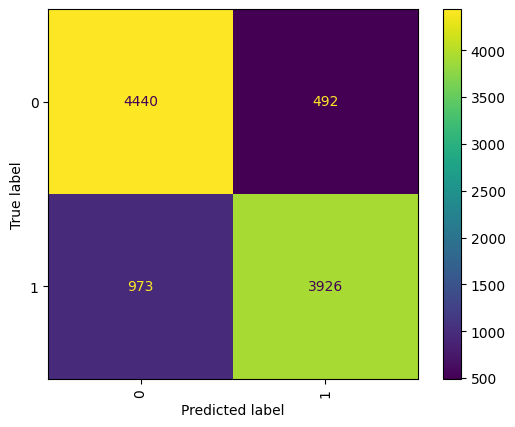

Accuracy: 0.8509815888515919
Precision: 0.8886373924852875
Recall: 0.8013880383751786
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86      4932
         1.0       0.89      0.80      0.84      4899

    accuracy                           0.85      9831
   macro avg       0.85      0.85      0.85      9831
weighted avg       0.85      0.85      0.85      9831



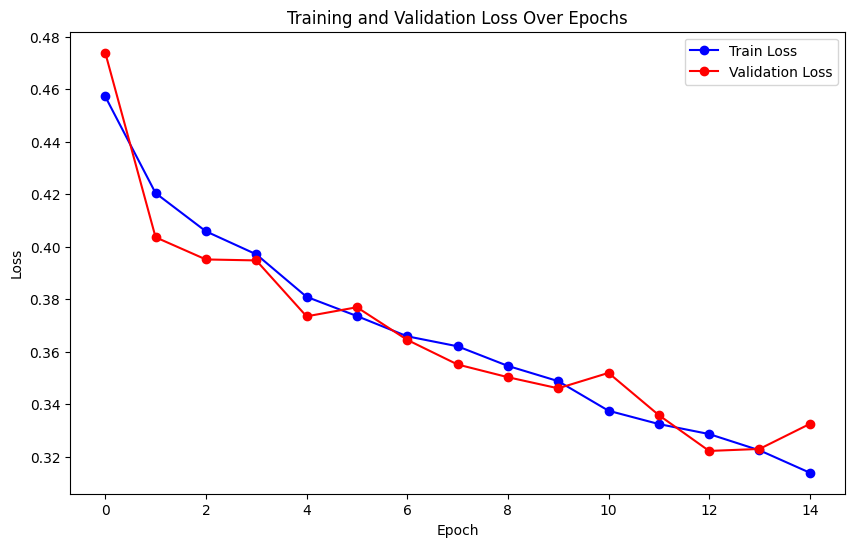

In [ ]:
classification_evaluation(total_train_losses_CRP2,total_val_losses_CRP2, val_preds_CRP2, val_lbl_CRP2)

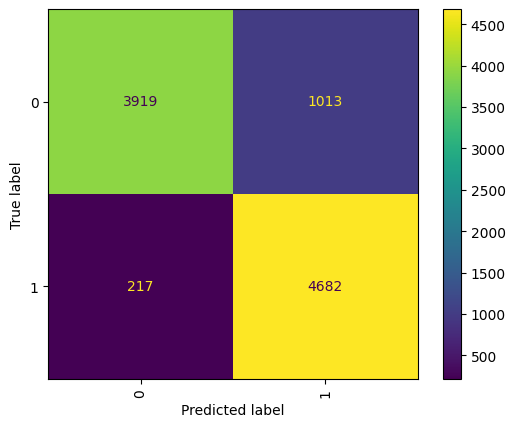

Accuracy: 0.8748855660665242
Precision: 0.8221246707638279
Recall: 0.955705245968565
              precision    recall  f1-score   support

         0.0       0.95      0.79      0.86      4932
         1.0       0.82      0.96      0.88      4899

    accuracy                           0.87      9831
   macro avg       0.88      0.88      0.87      9831
weighted avg       0.89      0.87      0.87      9831



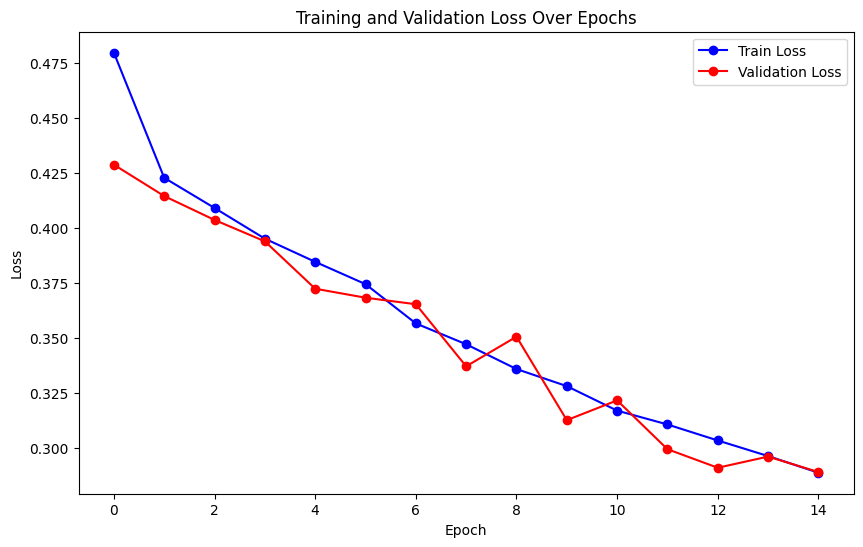

In [ ]:
classification_evaluation(total_train_losses_CRP3,total_val_losses_CRP3, val_preds_CRP3, val_lbl_CRP3)

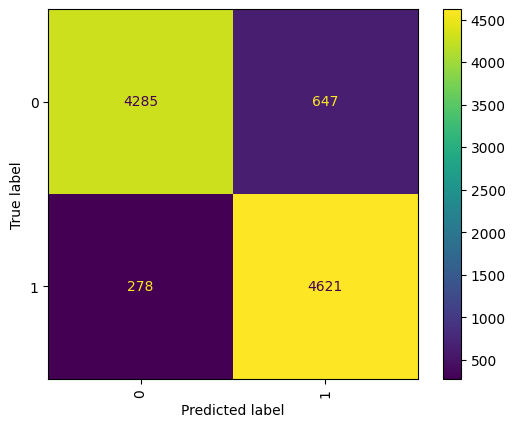

Accuracy: 0.9059098769199471
Precision: 0.8771829916476841
Recall: 0.943253725250051
              precision    recall  f1-score   support

         0.0       0.94      0.87      0.90      4932
         1.0       0.88      0.94      0.91      4899

    accuracy                           0.91      9831
   macro avg       0.91      0.91      0.91      9831
weighted avg       0.91      0.91      0.91      9831



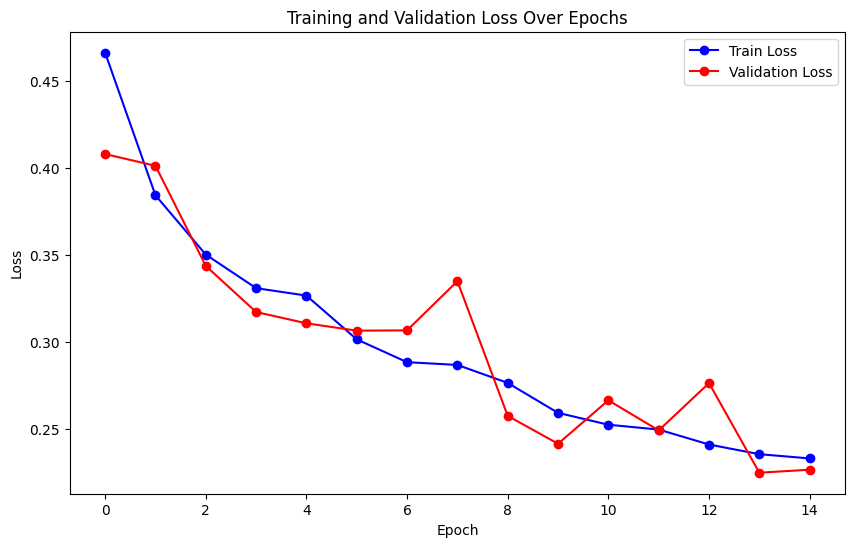

In [ ]:
classification_evaluation(total_train_losses_CCP2,total_val_losses_CCP2, val_preds_CCP2, val_lbl_CCP2)

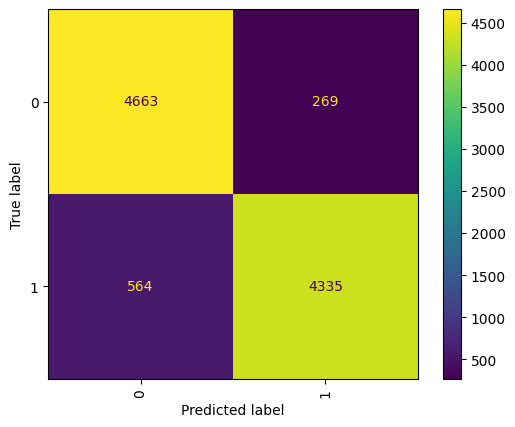

Accuracy: 0.9152680297019632
Precision: 0.9415725456125109
Recall: 0.8848744641763625
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      4932
         1.0       0.94      0.88      0.91      4899

    accuracy                           0.92      9831
   macro avg       0.92      0.92      0.92      9831
weighted avg       0.92      0.92      0.92      9831



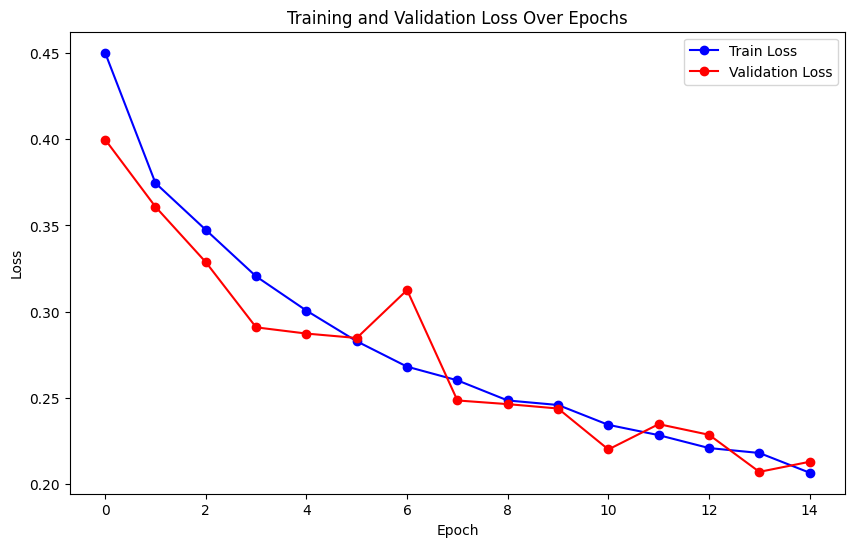

In [ ]:
classification_evaluation(total_train_losses_CCP3,total_val_losses_CCP3, val_preds_CCP3, val_lbl_CCP3)

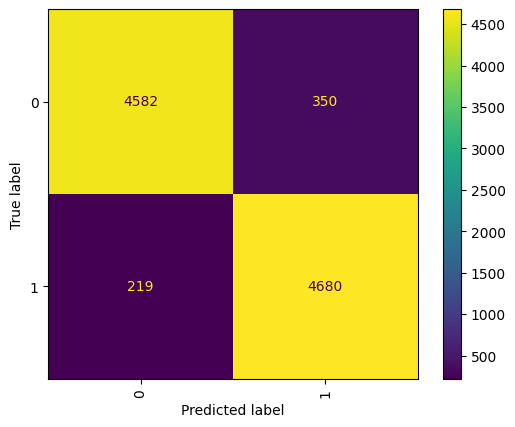

Accuracy: 0.9421218594242702
Precision: 0.9304174950298211
Recall: 0.9552969993876301
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      4932
         1.0       0.93      0.96      0.94      4899

    accuracy                           0.94      9831
   macro avg       0.94      0.94      0.94      9831
weighted avg       0.94      0.94      0.94      9831



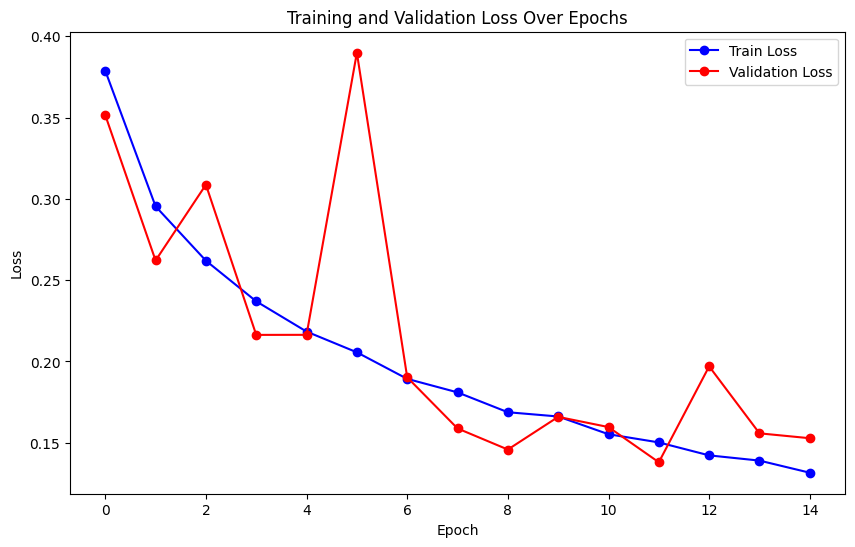

In [ ]:
classification_evaluation(total_train_losses_resnet18,total_val_losses_resnet18, val_preds_resnet18, val_lbl_resnet18)

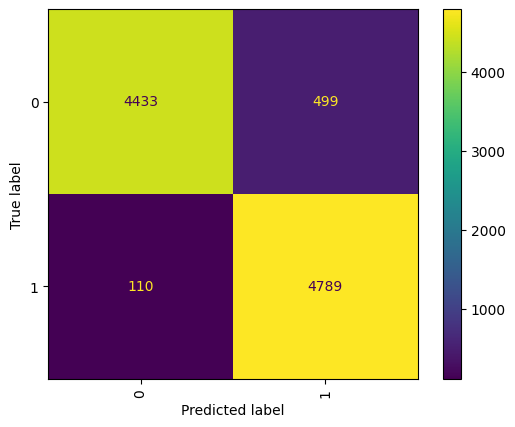

Accuracy: 0.9380530973451328
Precision: 0.9056354009077155
Recall: 0.9775464380485813
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      4932
         1.0       0.91      0.98      0.94      4899

    accuracy                           0.94      9831
   macro avg       0.94      0.94      0.94      9831
weighted avg       0.94      0.94      0.94      9831



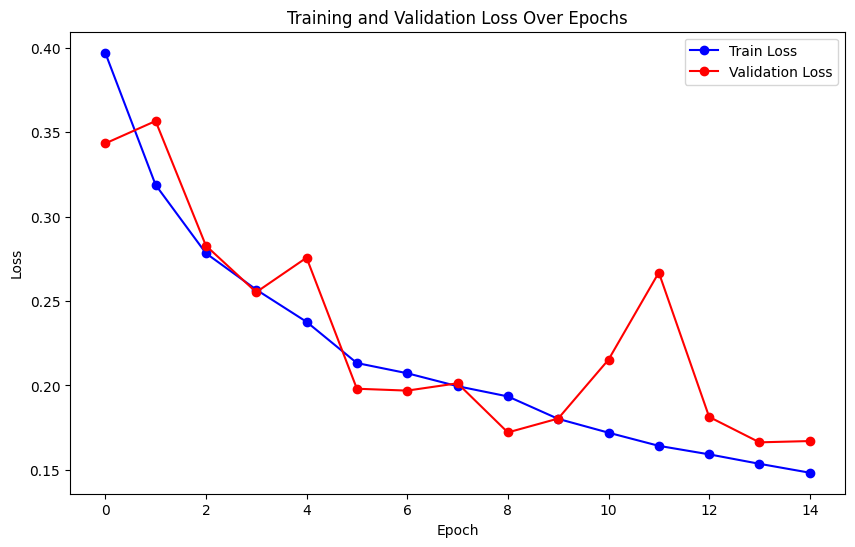

In [ ]:
classification_evaluation(total_train_losses_resnet34,total_val_losses_resnet34, val_preds_resnet34, val_lbl_resnet34)

**Conclusion** : 1.Both resnet have some volaitily in their test loss. They seems to overfit. We could reduce their overfitting by adding some dropout.
2. CCP3 seems the most promising model, with high recall, high accuracy and no overfitting.

We will thus optimize its parameters in the next section.

# VII. Hyperparameters optimization with gp_minimize

To do so, we will use bayesian optimization to find the best set of hyperparameters using the library `scikit-optimize`.

1. We will use the optmizing function `gp_minimize` that take into input a function we want to minimize,
2. We build the function we want to minimize : `fit_opt`. Basically, it returns the **negative** f1 score (as we want to minimize something) after training the model on a certain number of batches. **Just taking the recall score isn't sufficient, because if the model predicts everyone as 1, then the recall score is 1 but the model predicts poorly.**

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer,Categorical
from IPython.display import clear_output
from sklearn.metrics import f1_score

In [ ]:
# Retrieve the best set of hyperparameters using bayesian optimization.
# Declare search space for your set of hyperparameters (you may take a look here: https://scikit-optimize.github.io/stable/modules/space.html#space)

dimensions = [Real(name='learning_rate', low=1e-5, high=0.5, prior='log-uniform'),
              Categorical(name='batch_size',categories=[32, 64, 128, 256]),
              Integer(name='num_layers', low=2, high=6)]

parameters_default_values = [3e-4,64,3] # default value for each parameter for initialization

As 1 call involves training on all epochs, we reduce the number of epochs to 5 to see which model is most promising, and then we will train again with the optimal parameters.

In [ ]:
num_epochs=5

In [ ]:
# Create a function that take as input your set of hyperparameters and return a score to be minimized (choose wisely your scoring function)

@use_named_args(dimensions=dimensions)
def fit_opt(learning_rate, batch_size, num_layers):
    print("learning_rate", learning_rate)
    print("batch_size", batch_size)
    print("Number of CNN blocks : ", num_layers)

    train_loader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=int(batch_size), shuffle=False)

    params_model={
        "shape_in": (3,128),
        "num_CNN_blocks" :num_layers ,
        "filter_dim": 8,
        "fc_size": 100,
        "dropout_rate": 0.25}

    model = ConvConvPool(params_model).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    total_train_losses,total_val_losses, val_preds, val_lbl=training_loop(model,
                                          num_epochs,
                                          train_dataloader,
                                          val_dataloader,
                                          optimizer,
                                          criterion,
                                          device)
    clear_output(wait=True)
    classification_evaluation(total_train_losses,total_val_losses, val_preds, val_lbl)
    score = -f1_score(val_lbl, val_preds)

    return score

The minimum number of calls is 11.

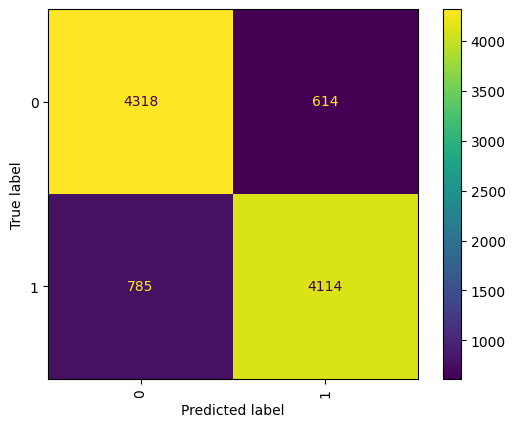

Accuracy: 0.8576950462821686
Precision: 0.8701353637901861
Recall: 0.8397632169830578
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      4932
         1.0       0.87      0.84      0.85      4899

    accuracy                           0.86      9831
   macro avg       0.86      0.86      0.86      9831
weighted avg       0.86      0.86      0.86      9831



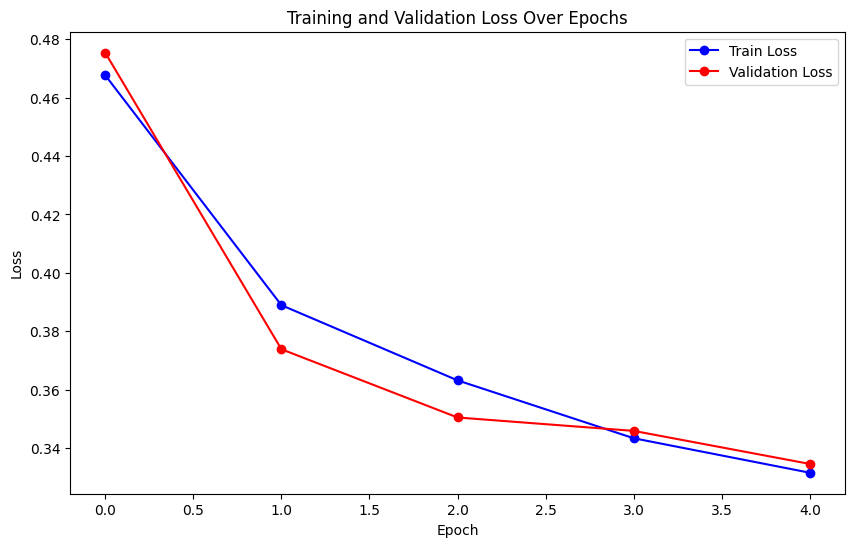

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 406.1377
Function value obtained: -0.8547
Current minimum: -0.8824
Optimal set of parameters found at iteration 0
[0.0003, 64, 3]


In [ ]:
# Use gp_minize to retrieve the optimal values (you may take a look here: https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html?highlight=gp_minimize#skopt.gp_minimize)

gp_result = gp_minimize(
    fit_opt, dimensions,n_calls = 15, random_state=42,x0=parameters_default_values, verbose = True, n_jobs = -1
    )

print(f"Optimal set of parameters found at iteration {np.argmin(gp_result.func_vals)}")
print(gp_result.x)

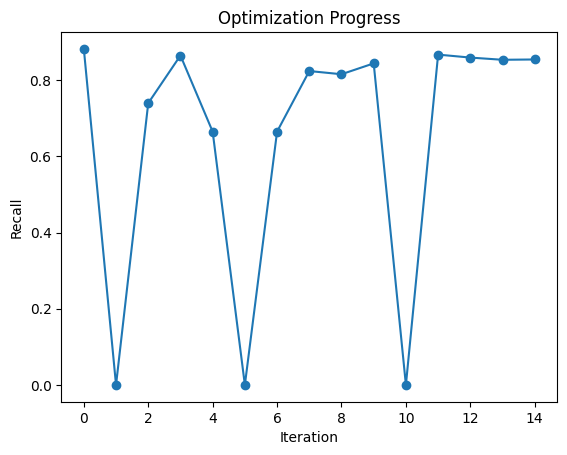

In [ ]:
# Plot the optimization results
plt.plot(-gp_result.func_vals, marker='o')
plt.title('Optimization Progress')
plt.xlabel('Iteration')
plt.ylabel('Recall')
plt.show()

In [ ]:
gp_result.x

[0.0003, 64, 3]

**Well the best model is... the initial one CCP3 ! Learning rate of 3e-4, batches of 64 and 3 CNN layers**.

# VIII. Visual Transformer

PyTorch provides an already implemented class of ViT, so let's use it !

In [ ]:
image_size = 128
patch_size = 16
num_layers = 4
num_heads=8
hidden_dim = 128
mlp_dim = 3072
num_classes = 1

In [ ]:
from torchvision.models.vision_transformer import VisionTransformer

In [ ]:
vit_model = VisionTransformer(image_size=image_size,
                              patch_size=patch_size,
                              num_layers=num_layers,
                              num_heads = num_heads,
                              hidden_dim = hidden_dim,
                              mlp_dim = mlp_dim,
                              num_classes = num_classes).to(device)

In [ ]:
# Define optimizer
optimizer = torch.optim.AdamW(vit_model.parameters(), lr=0.001)

In [ ]:
total_train_losses_vit,total_val_losses_vit, val_preds_vit, val_lbl_vit=training_loop(vit_model, num_epochs, train_dataloader, val_dataloader, optimizer, criterion, device)

epoch: 1


100%|██████████| 359/359 [01:32<00:00,  3.86it/s]


Train Loss :  0.6301 and Train Accuraccy :  0.6095 


100%|██████████| 154/154 [00:11<00:00, 12.96it/s]


Val Loss :  0.4955 and Val Accuraccy :  0.7642


epoch: 2


100%|██████████| 359/359 [01:14<00:00,  4.83it/s]


Train Loss :  0.4450 and Train Accuraccy :  0.7874 


100%|██████████| 154/154 [00:11<00:00, 13.05it/s]


Val Loss :  0.4282 and Val Accuraccy :  0.8055


epoch: 3


100%|██████████| 359/359 [01:14<00:00,  4.84it/s]


Train Loss :  0.4012 and Train Accuraccy :  0.8120 


100%|██████████| 154/154 [00:10<00:00, 14.05it/s]


Val Loss :  0.3892 and Val Accuraccy :  0.8183


epoch: 4


100%|██████████| 359/359 [01:13<00:00,  4.88it/s]


Train Loss :  0.3771 and Train Accuraccy :  0.8285 


100%|██████████| 154/154 [00:11<00:00, 13.07it/s]


Val Loss :  0.3777 and Val Accuraccy :  0.8183


epoch: 5


100%|██████████| 359/359 [01:13<00:00,  4.89it/s]


Train Loss :  0.3643 and Train Accuraccy :  0.8315 


100%|██████████| 154/154 [00:11<00:00, 13.02it/s]


Val Loss :  0.3792 and Val Accuraccy :  0.8233


epoch: 6


100%|██████████| 359/359 [01:12<00:00,  4.94it/s]


Train Loss :  0.3501 and Train Accuraccy :  0.8394 


100%|██████████| 154/154 [00:11<00:00, 13.56it/s]


Val Loss :  0.3435 and Val Accuraccy :  0.8439


epoch: 7


100%|██████████| 359/359 [01:14<00:00,  4.84it/s]


Train Loss :  0.3457 and Train Accuraccy :  0.8458 


100%|██████████| 154/154 [00:11<00:00, 12.96it/s]


Val Loss :  0.3433 and Val Accuraccy :  0.8459


epoch: 8


100%|██████████| 359/359 [01:14<00:00,  4.82it/s]


Train Loss :  0.3366 and Train Accuraccy :  0.8492 


100%|██████████| 154/154 [00:11<00:00, 13.66it/s]


Val Loss :  0.3290 and Val Accuraccy :  0.8501


epoch: 9


100%|██████████| 359/359 [01:14<00:00,  4.84it/s]


Train Loss :  0.3246 and Train Accuraccy :  0.8549 


100%|██████████| 154/154 [00:11<00:00, 13.05it/s]


Val Loss :  0.3376 and Val Accuraccy :  0.8502


epoch: 10


100%|██████████| 359/359 [01:13<00:00,  4.86it/s]


Train Loss :  0.3189 and Train Accuraccy :  0.8573 


100%|██████████| 154/154 [00:11<00:00, 12.86it/s]

Val Loss :  0.3046 and Val Accuraccy :  0.8652




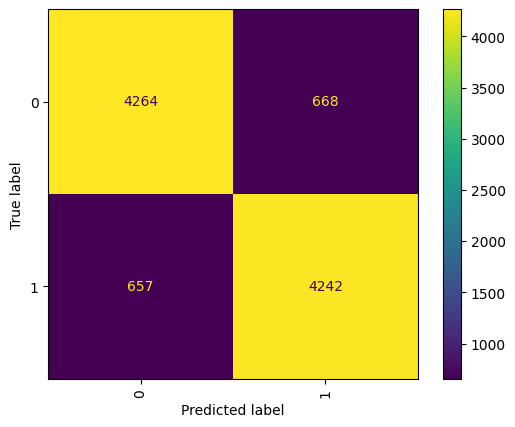

Accuracy: 0.8652222561285728
Precision: 0.8639511201629327
Recall: 0.8658909981628904
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.87      4932
         1.0       0.86      0.87      0.86      4899

    accuracy                           0.87      9831
   macro avg       0.87      0.87      0.87      9831
weighted avg       0.87      0.87      0.87      9831



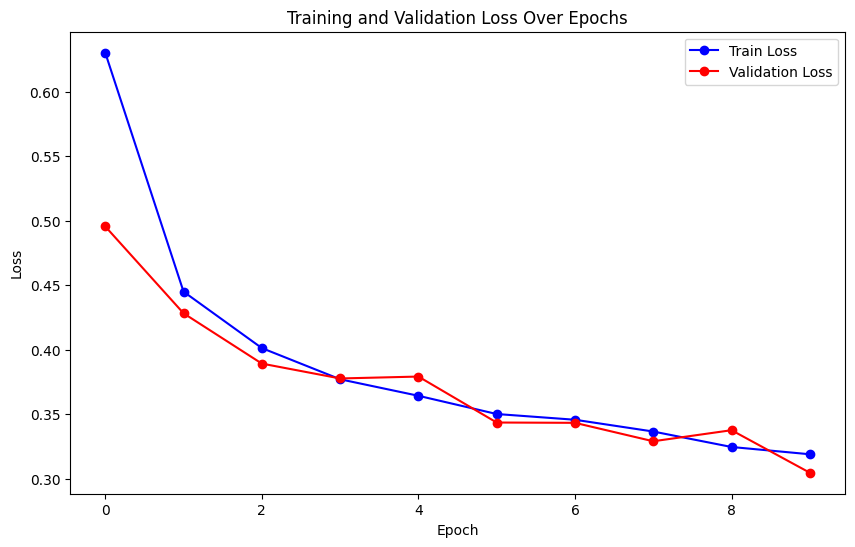

In [ ]:
classification_evaluation(total_train_losses_vit,total_val_losses_vit, val_preds_vit, val_lbl_vit)

**The model doesn't overfitting, and presents also good recall and precision scores. A fine tuning of its parameter could lead to better results.**

# IX. LIME and Saliency Map

How does your chosen method probe the classifications of your model? Do the results make sense?

With respect to the code block below, saliency maps are useful in interpreting the decisions of CNNs.

1. We will implement a Local Interpretable Model-Agnostic Explanations (Lime)
The subtility here is to define a function `batch_predict` takes into input an array (no tensor) and return a numpy value.
We will use the example code of the documentation : https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb
2. And then use the saliency map code.

## IX.1 LIME

In [ ]:
#!pip install lime

In [ ]:
img = images[24] #we will focus on this sample
model = CCP3 #we need the already trained CCP3

def get_pil_transform():
    ''' Transformer that resizes a picture'''

    transf = transforms.Compose([
        transforms.Resize((128, 128))
    ])

    return transf

def get_preprocess_transform():
    ''' Transformer that normalizes a picture'''
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    return transf

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()


def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = nn.functional.sigmoid(logits)
    return probs.detach().cpu().numpy()

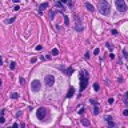

In [ ]:
import torch
from torchvision import transforms
from lime import lime_image
from PIL import Image

pil_img = Image.fromarray(img)
pill_transf(pil_img)

Let's see if our code works.

In [ ]:
test_pred = batch_predict([pill_transf(pil_img)])
test_pred

array([[0.97864735]], dtype=float32)

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(pil_img)),
                                         batch_predict, # classification function
                                         top_labels=1,
                                         hide_color=0,
                                         num_samples=1000) # number of images that will be sent to classificatio

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
from skimage.segmentation import mark_boundaries

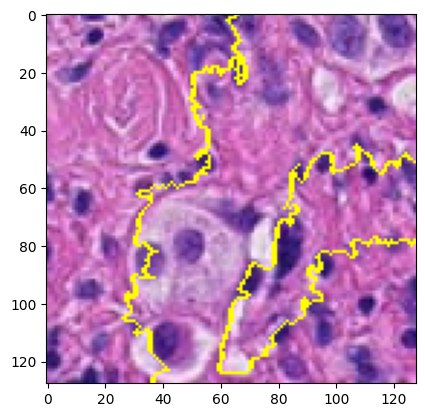

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

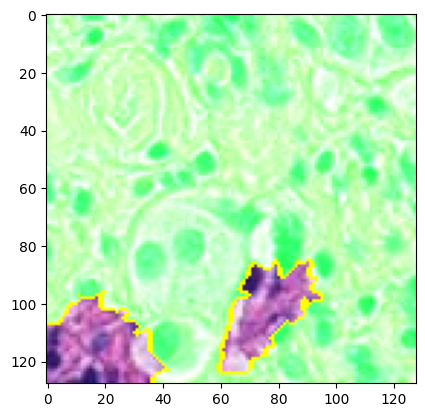

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

The Lime method underlines well the region that are considered as the most helpful ones ! We can see the tumor well bounded.  

## IX.2 Saliency Map

In [ ]:
def plot_saliency_map(model, image):
  '''Function that take into input an already trained model
  and plots the saliency map on a random validation image'''

  # Choose a particular image and corresponding label in which to investigate the classifications of the network

  ### Here put the transforms to be applied
  preprocess = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]),
                                  transforms.Resize((128,128), antialias=True)])


  input_tensor = preprocess(img).unsqueeze(0).to(device)  # Add batch dimension of 1 (not only 3x128x128)

  # Set the model to evaluation mode
  model.eval()

  # Set the requires_grad attribute of the input tensor to True for gradients
  input_tensor.requires_grad_(True)

  # Forward pass to get the model prediction

  output =model(input_tensor)


  # Choose the class index for which you want to visualize the saliency map
  class_index = torch.argmax(output)

  model.zero_grad()

  # Backward pass to get the gradients of the output w.r.t the input
  output[0, class_index].backward()

  # Get the gradients from the input tensor
  saliency_map = input_tensor.grad.squeeze(0).abs().cpu().numpy()

  # Normalize the saliency map for visualization (optional)
  saliency_map = saliency_map / saliency_map.max()

  normalized_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

  # Convert the saliency map back to a uint8 image format (0-255)
  saliency_map_image = np.uint8(255 * normalized_saliency_map)

  # Aggregate across the channels
  aggregate_saliency = saliency_map.sum(axis=0)

  # Plot the input image and its corresponding saliency map side by side
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  # Plot the input image
  axes[0].imshow(image)
  axes[0].set_title('Input Image')
  axes[0].axis('off')

  # Plot the saliency map
  axes[1].imshow(aggregate_saliency, cmap='jet', alpha=0.7)  # Overlay saliency map on the input image
  axes[1].imshow(image, alpha=0.3)  # Overlay input image for comparison
  axes[1].set_title('Saliency Map')
  axes[1].axis('off')


Let's plot the saliency maps for our best 2 models :

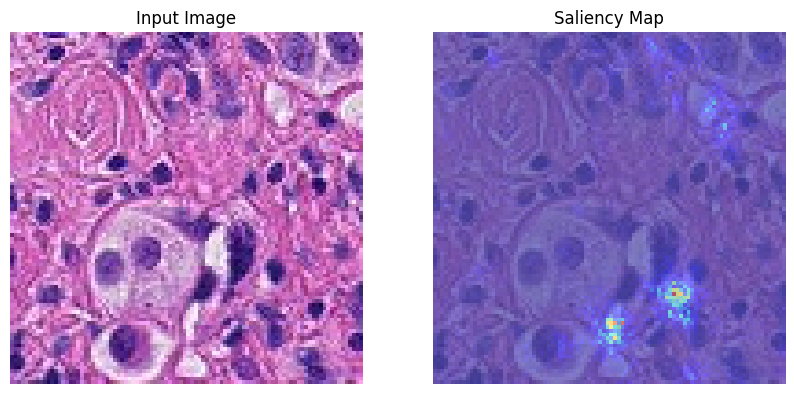

In [ ]:
plot_saliency_map(CCP3,pil_img)

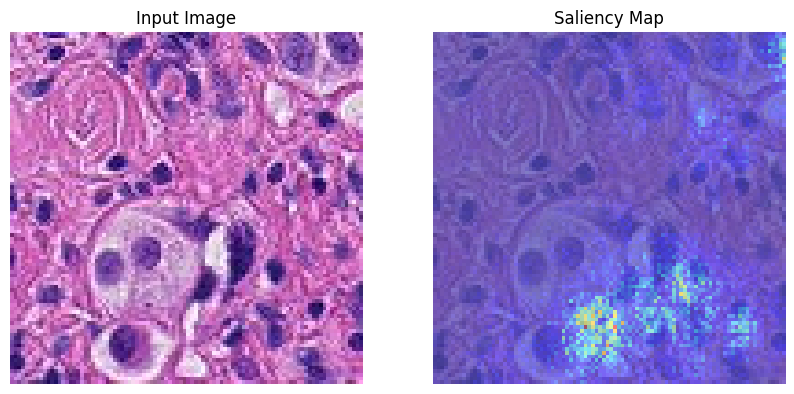

In [ ]:
plot_saliency_map(resnet_34, img)

# X. **Conclusion :**
1. The ResNet34 highlights a wider region of the picture and seems accurate. But we have to keep in mind that this model was overfitting.
2. The CCP3 was a model without overfitting but is more precise about the region that helped it. If we need to show such saliency maps to medical experts, we would for sure prefer to present the CCP3 that explains better the model.